<a href="https://colab.research.google.com/github/emmanuellaanggi/disaster_tweet_sentiment/blob/master/Real_or_Not_NLP_with_Disaster_Tweets_Kaggle_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis Using LSTM & CNN with fastText Word-Embedding!**

My first notebook with kaggle dataset!

This time i'm trying to apply the method of word-embedding that i used on one of my paper in uni: fastText. i tried it to classify this interesting dataset from kaggle. The dataset consisted of tweets and classifies whether a tweet is using a disaster words as to inform a real disaster or merely just use it metaphorically.

This was tested/built with Google Colab, so it'll work fine and just the same if you try it on Colab.

thank you to https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings!

# **Download Data from kaggle**

First, the data. first things first is installing kaggle to my environment i dont have to download the data to my drive/local. It's super efficient.

To get the API, go to your kaggle profile and download the JSON file!

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

download the dataset directly by copying the API command on the dataset page

In [2]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 62.5MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.2MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.7MB/s]


#**Downloading pre-trained fastText, preparing datasets, and pre-processing**

as i’ve mentioned, i am using fastText and i’m going to download the pre-trained model that fastText offered, directly to my session, and then unzip it to use.

In [3]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Converting all the words to index in number, to the embedding index in pre-trained model and converted all the missing words to 0,

In [5]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

2115it [00:00, 10869.75it/s]

loading word embeddings...


999995it [01:44, 9538.13it/s]

found 999995 word vectors


Read both the train data and test data

In [6]:
#load data
train_df = pd.read_csv('train.csv', sep=',', header=0)
test_df = pd.read_csv('test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  7613
Number of testing data:  3263


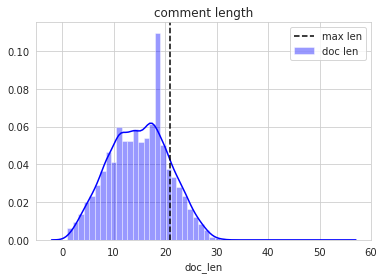

In [7]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

tokenizing the data with tokenizer from tensorflow

In [8]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

 13%|█▎        | 959/7613 [00:00<00:01, 4607.87it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 4971.25it/s]


tokenizing input data...
dictionary size:  28717


#**Shape and Train with LSTM**

defining variables that used on training

In [9]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

building the embedding matrix for the weights in Embedding Layer on training. more about embedding matrix: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

all words that aren't in the pre-trained model from fasttext would be changed to 0. the words are basically the ones with typos or names, the words mostly dont matter so much to the pattern. so it's nicer to just weights it 0.

In [13]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 14247


In [14]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['bftiapf35f' '2qjl5mfkzv' 'foragesecret' 'fl8gci84aj' 'boua80z5wf'
 'werk9qibvv' 'tpoptwmwfr' 'izjk6kpwiz' 'rpbxdfnx5k' 'cubdnsnuvt']


let's start training! here are the layers. i have been doing some test and modification on using the layer, unit cells, etc. and so far it works the best for me. tell me i

In [15]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
dropout (Dropout)            (None, 21, 300)           0         
_________________________________________________________________
dense (Dense)                (None, 21, 32)            9632      
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 128)           9

In [16]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 15s 723ms/step - loss: 0.6887 - accuracy: 0.5778 - val_loss: 0.6820 - val_accuracy: 0.5679
Epoch 2/40
21/21 [==============================] - 12s 553ms/step - loss: 0.6437 - accuracy: 0.6418 - val_loss: 0.5292 - val_accuracy: 0.7627
Epoch 3/40
21/21 [==============================] - 12s 563ms/step - loss: 0.5559 - accuracy: 0.7365 - val_loss: 0.4966 - val_accuracy: 0.7785
Epoch 4/40
21/21 [==============================] - 12s 561ms/step - loss: 0.4918 - accuracy: 0.7814 - val_loss: 0.4393 - val_accuracy: 0.8122
Epoch 5/40
21/21 [==============================] - 12s 557ms/step - loss: 0.4695 - accuracy: 0.7951 - val_loss: 0.4301 - val_accuracy: 0.8104
Epoch 6/40
21/21 [==============================] - 12s 557ms/step - loss: 0.4583 - accuracy: 0.8032 - val_loss: 0.4271 - val_accuracy: 0.8192
Epoch 7/40
21/21 [==============================] - 12s 558ms/step - loss: 0.4444 - accuracy: 0.8101 - val_loss: 0.4239 - val_accuracy: 0.8117

#**Evaluation**

evaluation on the training for each epoch

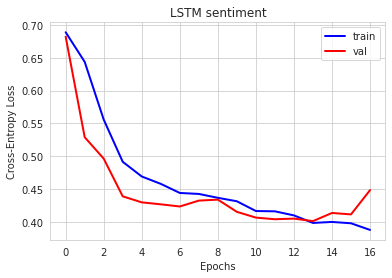

In [18]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

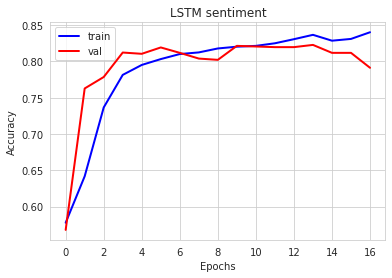

In [19]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(word_seq_test)

In [21]:
sample=pd.read_csv('sample_submission.csv')
sample['target']= (predictions>0.5).astype(int)
sample.to_csv("submission.csv",index=False, header=True)

In [ ]:
sample.head(20)

In [ ]:
# i'll try to submit this and know the accuracy if applied to real test
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using LSTM with fastText Word-Embedding"

it's **80%**! not so good but also not that bad, huh?

# **LET'S COMPARE!**

which one is more interesting to compare first? the using of lstm vs cnn? or the fasttext vs glove? let's try to compare the easiest one--for me at least dont judge me!--the model.

next up i'll show the comparation of fasttext and glove using the model that works better.

In [24]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [25]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 64)            134464    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)

In [26]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 2s 111ms/step - loss: 0.6805 - accuracy: 0.5761 - val_loss: 0.6252 - val_accuracy: 0.7412
Epoch 2/40
21/21 [==============================] - 2s 103ms/step - loss: 0.5824 - accuracy: 0.7226 - val_loss: 0.4965 - val_accuracy: 0.7955
Epoch 3/40
21/21 [==============================] - 2s 104ms/step - loss: 0.4842 - accuracy: 0.7865 - val_loss: 0.4360 - val_accuracy: 0.8174
Epoch 4/40
21/21 [==============================] - 2s 103ms/step - loss: 0.4293 - accuracy: 0.8221 - val_loss: 0.4618 - val_accuracy: 0.7898
Epoch 5/40
21/21 [==============================] - 2s 103ms/step - loss: 0.4167 - accuracy: 0.8277 - val_loss: 0.4541 - val_accuracy: 0.7912
Epoch 6/40
21/21 [==============================] - 2s 103ms/step - loss: 0.3978 - accuracy: 0.8371 - val_loss: 0.4418 - val_accuracy: 0.8095


evaluation on the training for each epoch with this model

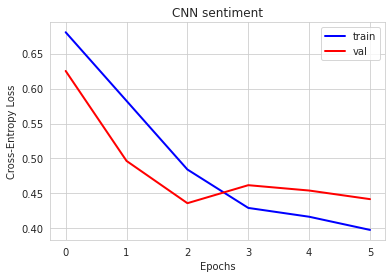

In [36]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

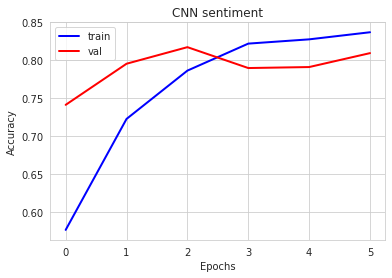

In [35]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [30]:
predictions = model.predict_classes(word_seq_test)

In [31]:
sample=pd.read_csv('sample_submission.csv')
sample['target']= (predictions>0.5).astype(int)
sample.to_csv("submission.csv",index=False, header=True)

In [ ]:
sample.head(20)

In [34]:
# i'll try to submit this and know the accuracy if applied to real test
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using CNN with fastText Word-Embedding"

100% 22.2k/22.2k [00:02<00:00, 11.3kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

it's **79.4%**! but this one was using less epoch. what do you think?

###### **next up is using glove! im excited! with what i promised, i'll use the better performance. with the time and result, i'll just use cnn again!**

In [37]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()


Converting all the words to index in number, to the embedding index in pre-trained model and converted all the missing words to 0,

In [38]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('glove.6B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1866it [00:00, 9553.06it/s]

loading word embeddings...


400000it [00:47, 8486.36it/s]

found 400000 word vectors


tokenizing the data with tokenizer from tensorflow

In [42]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  6%|▌         | 474/7613 [00:00<00:01, 4738.36it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 3965.06it/s]


tokenizing input data...
dictionary size:  28717


defining variables that used on training

In [43]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

building the embedding matrix for the weights in Embedding Layer on training. more about embedding matrix: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [44]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 13620


In [45]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['dinallyhot' 't8uqm7imir' 'jet\x89ûªs' 'shizune' 'catwoman1775' 'vjday70'
 'zgjgghdurf' 's0eyq1wehe' '6qc8whdizy' 'efc3896qgr']


wait.. fastText has more null words?

In [46]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [47]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 64)            134464    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)

In [48]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 2s 109ms/step - loss: 0.6707 - accuracy: 0.6275 - val_loss: 0.5622 - val_accuracy: 0.7053
Epoch 2/40
21/21 [==============================] - 2s 103ms/step - loss: 0.5276 - accuracy: 0.7624 - val_loss: 0.4746 - val_accuracy: 0.7907
Epoch 3/40
21/21 [==============================] - 2s 105ms/step - loss: 0.4565 - accuracy: 0.8035 - val_loss: 0.4672 - val_accuracy: 0.8008
Epoch 4/40
21/21 [==============================] - 2s 103ms/step - loss: 0.4131 - accuracy: 0.8292 - val_loss: 0.4551 - val_accuracy: 0.8060
Epoch 5/40
21/21 [==============================] - 2s 104ms/step - loss: 0.3703 - accuracy: 0.8534 - val_loss: 0.4398 - val_accuracy: 0.8126
Epoch 6/40
21/21 [==============================] - 3s 156ms/step - loss: 0.3335 - accuracy: 0.8694 - val_loss: 0.4569 - val_accuracy: 0.8087
Epoch 7/40
21/21 [==============================] - 2s 106ms/step - loss: 0.2914 - accuracy: 0.8925 - val_loss: 0.4723 - val_accuracy: 0.8030
Epoch 

In [50]:
predictions = model.predict_classes(word_seq_test)

In [51]:
sample=pd.read_csv('sample_submission.csv')
sample['target']= (predictions>0.5).astype(int)
sample.to_csv("submission.csv",index=False, header=True)

In [ ]:
sample.head(20)

In [54]:
# i'll try to submit this and know the accuracy if applied to real test
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using CNN with Glove Word-Embedding"

100% 22.2k/22.2k [00:03<00:00, 7.06kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

well, the result is **79.5%**! it's the almost the same with cnn using fastText. on training, it shows a higher number on accuracy tho..

###**anyway i'm not satisfied yet so im just gonna tried LSTM using glove.**

In [55]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [56]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
dropout (Dropout)            (None, 21, 300)           0         
_________________________________________________________________
dense (Dense)                (None, 21, 32)            9632      
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 128)           9

In [57]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
21/21 [==============================] - 16s 747ms/step - loss: 0.6512 - accuracy: 0.6371 - val_loss: 0.5185 - val_accuracy: 0.7666
Epoch 2/40
21/21 [==============================] - 12s 587ms/step - loss: 0.5265 - accuracy: 0.7664 - val_loss: 0.4814 - val_accuracy: 0.7898
Epoch 3/40
21/21 [==============================] - 12s 590ms/step - loss: 0.4905 - accuracy: 0.7887 - val_loss: 0.4640 - val_accuracy: 0.7929
Epoch 4/40
21/21 [==============================] - 12s 587ms/step - loss: 0.4717 - accuracy: 0.7925 - val_loss: 0.4529 - val_accuracy: 0.7973
Epoch 5/40
21/21 [==============================] - 13s 599ms/step - loss: 0.4571 - accuracy: 0.8018 - val_loss: 0.4359 - val_accuracy: 0.8087
Epoch 6/40
21/21 [==============================] - 12s 590ms/step - loss: 0.4428 - accuracy: 0.8105 - val_loss: 0.4329 - val_accuracy: 0.7986
Epoch 7/40
21/21 [==============================] - 12s 589ms/step - loss: 0.4390 - accuracy: 0.8161 - val_loss: 0.4233 - val_accuracy: 0.8148

In [59]:
predictions = model.predict_classes(word_seq_test)

In [60]:
sample=pd.read_csv('sample_submission.csv')
sample['target']= (predictions>0.5).astype(int)
sample.to_csv("submission.csv",index=False, header=True)

In [ ]:
sample.head(20)

In [62]:
# i'll try to submit this and know the accuracy if applied to real test
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using LSTM with Glove Word-Embedding"

100% 22.2k/22.2k [00:01<00:00, 16.1kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

**it's 79.6%!**

**well, so far from my experiments, fastText and LSTM showed the best performance. but it's still not very sure if it's really like that because validation splitting influence the performance too, also how i build the layers, choosing batch size, optimizer, and stuff.**

**thank you if youre reading the comments too! i hope you have a great day!**